In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import tensorflow
import keras
from tensorflow.keras.applications import VGG19
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.layers as layers
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics
from scipy import stats
import json

2023-04-28 01:40:35.952429: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
/home/jiehyun.kim001/miniconda3/envs/O/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
import cactas as C

In [4]:
asymp_img = np.load('/raid/mpsych/CACTAS/DATA/ESUS/asymp_cropped_no_norm.npy')
symp_img = np.load('/raid/mpsych/CACTAS/DATA/ESUS/symp_cropped_no_norm.npy')
asymp_label = np.load('/raid/mpsych/CACTAS/DATA/ESUS/asymp_cropped_labels_no_norm.npy')
symp_label = np.load('/raid/mpsych/CACTAS/DATA/ESUS/symp_cropped_labels_no_norm.npy')

In [5]:
labels = np.concatenate((asymp_label, symp_label))
images = np.concatenate((asymp_img, symp_img))

In [6]:
labels.shape

(1417, 28, 28, 1)

In [7]:
images.shape

(1417, 28, 28, 1)

In [8]:
def split(images, labels, val_size=0.15):
    with open("symp_data.json", "r") as fp:
        symp_data = json.load(fp)
    with open("asymp_data.json", "r") as fp:
        asymp_data = json.load(fp)
        
    diffs = []
    prev_val = None
    for key in sorted(symp_data.keys(), key=int):
        val = symp_data[key]
        if prev_val is not None:
            diff = val - prev_val
            diffs.append(diff)
        prev_val = val


    symp_list = [711]
    result = 711
    for i in diffs:
        result += i
        symp_list.append(result)
        
    values = list(asymp_data.values()) + symp_list
        
    length = images.shape[0]
    num = round(length * (1 - val_size))

    nearest_bigger_value = None
    for value in values:
        if value > num:
            if nearest_bigger_value is None or value < nearest_bigger_value:
                nearest_bigger_value = value

    index = values.index(nearest_bigger_value) 

    X_train = images[0:values[index]] 
    y_train = labels[0:values[index]]
    X_val = images[values[index]:]
    y_val = labels[values[index]:]
    
    return X_train, X_val, y_train, y_val

In [9]:
train_f1 = []
test_f1 = []
for i in range(10):
    X, y = shuffle(images, labels, random_state=0)
    X_train, X_val, y_train, y_val = split(X, y, val_size=0.15)
    rf = RandomForestClassifier(n_estimators=100)
    
    X_train_raveled = X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2])
    X_val_raveled = X_val.reshape(X_val.shape[0], X_val.shape[1]*X_val.shape[2])
    y_train_raveled = y_train.reshape(y_train.shape[0], y_train.shape[1]*y_train.shape[2])
    y_val_raveled = y_val.reshape(y_val.shape[0], y_val.shape[1]*y_val.shape[2])


    fitted = rf.fit(X_train_raveled, y_train_raveled)
    
    y_pred = rf.predict(X_val_raveled)
    
    
    f1 = sklearn.metrics.f1_score(y_val_raveled, y_pred, average='micro')
    train_f1.append(f1)
    print('run', i, 'acc', sklearn.metrics.accuracy_score(y_val_raveled, y_pred), 'f1', f1)
    
    asymp_img_test = np.load('/raid/mpsych/CACTAS/DATA/ESUS/asymp_cropped.npy')
    symp_img_test = np.load('/raid/mpsych/CACTAS/DATA/ESUS/symp_cropped.npy')
    asymp_label_test = np.load('/raid/mpsych/CACTAS/DATA/ESUS/asymp_labels_cropped.npy')
    symp_label_test = np.load('/raid/mpsych/CACTAS/DATA/ESUS/symp_labels_cropped.npy')

    labels_test = np.concatenate((asymp_label_test, symp_label_test))
    images_test = np.concatenate((asymp_img_test, symp_img_test))
    
    X_test, y_test = shuffle(images_test, labels_test, random_state=0)
    
    X_test_raveled = X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2])
    y_test_raveled = y_test.reshape(y_test.shape[0], y_test.shape[1]*y_test.shape[2])
    
    y_pred = rf.predict(X_test_raveled)
    
    test_acc = sklearn.metrics.accuracy_score(y_test_raveled, y_pred)
    c_test_f1 = sklearn.metrics.f1_score(y_test_raveled, y_pred, average='micro')
    print('test run', i, 'acc', test_acc, 'f1', c_test_f1)
    
    test_f1.append(c_test_f1)


run 0 acc 0.009852216748768473 f1 0.5319092594227204
test run 0 acc 0.002117148906139732 f1 0.49629725149215237
run 1 acc 0.0049261083743842365 f1 0.5263250883392226
test run 1 acc 0.0014114326040931546 f1 0.5042672064022088
run 2 acc 0.0049261083743842365 f1 0.5286624203821656
test run 2 acc 0.002117148906139732 f1 0.4976900384065904
run 3 acc 0.0049261083743842365 f1 0.5269408011343495
test run 3 acc 0.0014114326040931546 f1 0.497405145696943
run 4 acc 0.0 f1 0.5267722807328082
test run 4 acc 0.0014114326040931546 f1 0.49747132334078503
run 5 acc 0.0049261083743842365 f1 0.5290322580645161
test run 5 acc 0.0014114326040931546 f1 0.49549615125652835
run 6 acc 0.0 f1 0.52827197463449
test run 6 acc 0.0014114326040931546 f1 0.49883351397027764
run 7 acc 0.0 f1 0.5259998234307407
test run 7 acc 0.0014114326040931546 f1 0.5014347269345447
run 8 acc 0.0 f1 0.5345403410089646
test run 8 acc 0.002117148906139732 f1 0.49833868996423886
run 9 acc 0.0049261083743842365 f1 0.5284316318434276
tes

In [10]:
def boxplot(all_data, labels, y_label='Time [s]', y_lim_min=0, y_lim=1000, title=None, outputdir='/home/jiehyun.kim001/CACTAS/_EXPERIMENTS/'):
    matplotlib.rcParams.update({'font.size': 32})
    plt.rc('axes', labelsize=65)    # fontsize of the x and y labels
    plt.rc('legend', fontsize=32)   
    plt.rc('xtick', labelsize=42) 

    # fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=1, figsize=(9, 4))
    fig = plt.figure(figsize=(7, 13))
    ax = fig.gca()
    # ax1 = plt.gcf()
    boxprops = dict(color="black",linewidth=1.5)
    medianprops = dict(color="black",linewidth=1.5)
    # rectangular box plot
    bplot1 = plt.boxplot(all_data,
                         vert=True,  # vertical box alignment
                         patch_artist=True,  # fill with color
                         labels=labels,
                         boxprops=boxprops,
                         medianprops=medianprops)  # will be used to label x-ticks

    # fill with colors
    colors = ['#af8dc3', '#7fbf7b']
    # for bplot in (bplot1, bplot2):
    for patch, color in zip(bplot1['boxes'], colors):
        patch.set_facecolor(color)

    ax.set_ylabel(y_label)
    ax.set_ylim(y_lim_min,y_lim)

    titleb = title
    if not title:
        titleb = 'figure.pdf'



    filename_pdf = outputdir+'/'+titleb.replace(' ','_').replace(',','')+'.pdf'
    filename_png = outputdir+'/'+titleb.replace(' ','_').replace(',','')+'.png'
    plt.savefig(filename_pdf,bbox_inches='tight')
    plt.savefig(filename_png,bbox_inches='tight')

    if title:
        plt.title(title)


    plt.show()



    print(labels[0], np.mean(all_data[0]),'+/-', np.std(all_data[0]))
    print(labels[1], np.mean(all_data[1]),'+/-', np.std(all_data[1]))

    ttest = stats.ttest_ind(all_data[0],all_data[1])

    print('t_'+str(len(all_data[0]+all_data[1])), '=', str(round(ttest[0],3)), ',p=',str(round(ttest[1],2)))

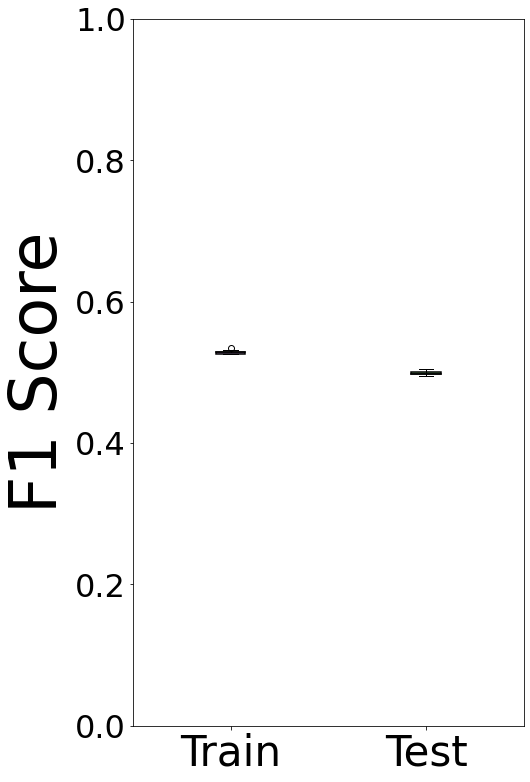

Train 0.5286885878993405 +/- 0.002540013833361448
Test 0.498995046124465 +/- 0.0027226110727636517
t_20 = 23.924 ,p= 0.0


In [11]:
data = [train_f1, test_f1]
labels = ['Train', 'Test']
boxplot(data, labels, y_lim=1, y_label='F1 Score', outputdir='/home/jiehyun.kim001/CACTAS/_EXPERIMENTS/')